<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_CNN_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CTU-IoT-Malware-Capture-1-1 data preprocessing and baseline (supervised) CNN model
- Collection
- Cleaning
- Encoding
- Scaling
- Normalisation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Step 1: Data Collection
data_file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/IoT-23 8GB Dataset/Malware-Project/BigDataset/IoTScenarios/CTU-IoT-Malware-Capture-1-1/bro/conn.log.labeled' # 1-1, 34-1, 49-1

# Read the file
df = pd.read_csv(
    data_file_path,
    sep="\t",
    comment="#",
    header=None,
    names=[
        "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
        "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
        "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
        "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "label"
    ]
)

print("\nInitial sample:")
print(df.head().to_string())

# Step 2: Data Cleaning
# Convert timestamp to datetime
df["ts"] = pd.to_datetime(df["ts"], unit="s", errors='coerce')

# Drop non-informative or redundant columns
df.drop(columns=['uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'history'], inplace=True)

# Replace '-' with NaN for consistent handling
df.replace('-', np.nan, inplace=True)

# Drop rows where critical numeric fields are missing
df.dropna(subset=[
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'
], inplace=True)

# Convert appropriate columns to numeric types
numeric_columns = [
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'missed_bytes'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Encode categorical columns
categorical_columns = ['proto', 'conn_state', 'service']
for col in categorical_columns:
    df[col] = df[col].astype(str)  # Ensure strings
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert label to binary (malicious=1, benign=0)
df['label'] = df['label'].apply(lambda x: 1 if 'Malicious' in str(x) else 0)

# Drop any rows still containing NaN
df.dropna(inplace=True)

print("\nCleaned sample:")
print(df.head().to_string())
print("\nData types and nulls:")
print(df.info())
# print("\nStatistics:")
# print(df.describe().to_string())


# --- Split features and labels ---
X = df.drop(columns=['label', 'ts']).values  # Drop label and timestamp
y = df['label'].values

# --- Normalize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- Add counts of malware and benign logs ---
total_logs = len(df)
malware_logs = df['label'].sum()  # since malware=1
benign_logs = total_logs - malware_logs

print(f"\nTotal logs: {total_logs}")
print(f"Malware logs: {malware_logs}")
print(f"Benign (non-malicious) logs: {benign_logs}")



Initial sample:
             ts                 uid        id.orig_h  id.orig_p        id.resp_h  id.resp_p proto service  duration orig_bytes resp_bytes conn_state local_orig local_resp  missed_bytes history  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes                                            label
0  1.525880e+09  CUmrqr4svHuSXJy5z7  192.168.100.103      51524   65.127.233.163         23   tcp       -  2.999051          0          0         S0          -          -             0       S          3            180          0              0  (empty)   Malicious   PartOfAHorizontalPortScan
1  1.525880e+09  CH98aB3s1kJeq6SFOc  192.168.100.103      56305    63.150.16.171         23   tcp       -         -          -          -         S0          -          -             0       S          1             60          0              0  (empty)   Malicious   PartOfAHorizontalPortScan
2  1.525880e+09   C3GBTkINvXNjVGtN5  192.168.100.103      41101     111.40.23.49         23   tcp    

# Pad & Reshape for 2D CNN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# # --- Split features and labels ---
# X = df.drop(columns=['label', 'ts']).values  # Drop label and timestamp
# y = df['label'].values

# # --- Normalize ---
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# --- Pad/truncate to 16 features for 4x4 reshape ---
target_feature_count = 16
current_feature_count = X_scaled.shape[1]

if current_feature_count < target_feature_count:
    # Pad with zeros
    pad_width = target_feature_count - current_feature_count
    X_padded = np.pad(X_scaled, ((0, 0), (0, pad_width)), mode='constant')
else:
    # Truncate extra columns
    X_padded = X_scaled[:, :target_feature_count]

# --- Reshape into (samples, 4, 4, 1) for 2D CNN input ---
X_2dcnn = X_padded.reshape(-1, 4, 4, 1) #CNN input shape: (total_samples, height, width, channels)

# --- Testing ---
# print("X-cnn:")
# print(X_cnn)
# print("Before reshape (sample 0):", X[0])
print("After reshape (sample 0):", X_2dcnn[0])


# Step 1: Split off the test set (e.g., 20%)
X2_temp, X2_test, y2_temp, y2_test = train_test_split(X_2dcnn, y, test_size=0.2, random_state=42, stratify=y) #  stratify=y ensures that the class distribution (e.g., number of benign vs. malicious labels) in the split matches the original dataset's distribution.

# Step 2: Split remaining data into training and validation sets (e.g., 20% val from temp)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_temp, y2_temp, test_size=0.2, random_state=42, stratify=y2_temp) #ensures class balance in both the training and validation sets

print("CNN input shape:", X_2dcnn.shape)


After reshape (sample 0): [[[ 0.53280701]
  [-0.52457017]
  [-0.11968774]
  [ 0.12429118]]

 [[-0.04855243]
  [-0.20352119]
  [-0.12056746]
  [-0.02812535]]

 [[ 0.        ]
  [-0.11265215]
  [-0.11029572]
  [-0.16961599]]

 [[-0.16652979]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]]
CNN input shape: (212448, 4, 4, 1)


#Build the 2D CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# --- Build model ---
#This Sequential model is a Convolutional Neural Network (CNN) built using Keras, designed for binary classification (e.g., "benign" vs. "malicious").

model = Sequential([                                                # Model Definition - This creates a linear stack of layers — meaning each layer has exactly one input and one output.
    Conv2D(32, (2, 2), activation='relu', input_shape=(4, 4, 1)),   # A convolutional layer that scans small regions of the input image (feature extractor), 32: Number of filters (kernels)(hyperparameter) — the model will learn 32 features from the input, (2, 2): Size of each filter — each filter scans a 2×2 patch of the input, Applies the ReLU activation function to introduce non-linearity, nput has shape 4×4 with 1 channel (i.e., grayscale or single feature).
    MaxPooling2D(pool_size=(2, 2)),                                 # Reduces the spatial dimensions of the feature maps (downsampling), (2, 2) takes the maximum value in each 2×2 window, reducing size and computation - helps retain the most important features and reduce overfitting.
    Flatten(),                                                      # Flattens the 2D pooled feature maps into a 1D vector.
    Dense(64, activation='relu'),                                   # Fully connected layer with 64 neurons - learns complex combinations of the features extracted by the convolutional layers. ReLU activation introduces non-linearity.
    Dropout(0.3),                                                   # Randomly "drops" (sets to zero) 30% of the neurons during training - Prevents overfitting by forcing the model to not rely on specific neurons.
    Dense(1, activation='sigmoid')                                  # Final output layer for binary classification, 1 neuron: outputs a single probability value (between 0 and 1). sigmoid activation: squashes the output to a probability — you’ll classify as class 1 if the output is > 0.5, otherwise 0.

])

# --- Compile ---
#This step prepares the model for training
# - optimizer='adam': Adam adapts the learning rate during training based on gradient history.
# - loss='binary_crossentropy': the loss function the model tries to minimize. It measures how well the model's predicted probabilities match the actual labels (0 or 1).
# - metrics=['accuracy']: tells the model to track accuracy during training and evaluation.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train, Evaluate (Test) & Visualize 2D CNN

Epoch 1/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9709 - loss: 0.1491 - val_accuracy: 0.9852 - val_loss: 0.0682
Epoch 2/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9864 - loss: 0.0676 - val_accuracy: 0.9866 - val_loss: 0.0615
Epoch 3/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9872 - loss: 0.0623 - val_accuracy: 0.9874 - val_loss: 0.0571
Epoch 4/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9875 - loss: 0.0590 - val_accuracy: 0.9877 - val_loss: 0.0518
Epoch 5/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9883 - loss: 0.0517 - val_accuracy: 0.9883 - val_loss: 0.0481
Epoch 6/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9886 - loss: 0.0492 - val_accuracy: 0.9914 - val_loss: 0.0443
Epoch 7/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9911 - loss: 0.0423 - val_accuracy: 0.9915 - val_loss: 0.0398
Epoch 8/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9917 - loss: 0.0434 -

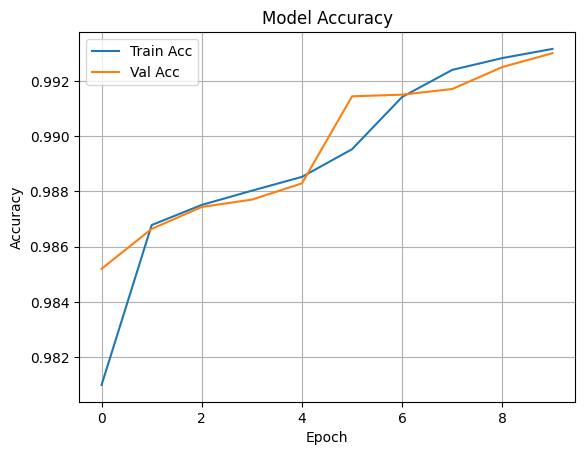

In [ ]:
import matplotlib.pyplot as plt

# --- Train with validation data ---
#This starts the training process, where the model learns patterns from X_train to predict y_train
history = model.fit(                 # The training history (loss & accuracy per epoch) is saved in history.
    X2_train,
    y2_train,
    epochs=10,                       # The model will go through the entire training data 10 times.
    batch_size=64,                   # The model updates its weights after every 64 samples (a batch) - speeds up training.
    validation_data=(X2_val, y2_val) ) # A separate dataset the model uses to evaluate its performance after each epoch — without updating weights. It helps monitor if the model is learning well or overfitting. [validation_data=(X_test, y_test))]


# --- Evaluate on test set ---
#This evaluates the final performance of your trained model on a completely unseen test set
test_loss, test_acc = model.evaluate(X2_test, y2_test)
print(f"\nTest accuracy: {test_acc:.4f}")

# --- Making sure the evaluation is trustworthy ---
print(X2_test.shape, y2_test.shape) #Shapes should match expected input/output dimensions.

y_pred_probs = model.predict(X2_test) #Compare with Manual Accuracy Calculation
y_pred = (y_pred_probs > 0.5).astype(int)  # threshold for binary classification
manual_acc = np.mean(y_pred.reshape(-1) == y2_test.reshape(-1))
print("Manual accuracy:", manual_acc)

# --- Plot training history ---
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


#Evaluate 2D CNN Malware Detection Results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions
y_pred_probs = model.predict(X2_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# Confusion matrix
cm = confusion_matrix(y2_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy score
print("sklearn accuracy:", accuracy_score(y2_test, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y2_test, y_pred, target_names=["Benign", "Malicious"]))


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Confusion Matrix:
[[ 4362   269]
 [    1 37858]]

True Negatives (Benign correctly classified): 4362
False Positives (Benign misclassified as malware): 269
False Negatives (Malware missed): 1
True Positives (Malware correctly identified): 37858
sklearn accuracy: 0.9936455636620382

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.94      0.97      4631
   Malicious       0.99      1.00      1.00     37859

    accuracy                           0.99     42490
   macro avg       1.00      0.97      0.98     42490
weighted avg       0.99      0.99      0.99     42490



#Quantize the 2D CNN Model (Float32 + Int8)
Converting a model's weights and activations from 32-bit floating point (float32) to smaller, more efficient data type, int8 (8-bit integers).

In [ ]:
import tensorflow as tf
import numpy as np
import os

def representative_dataset():
    for i in range(min(1000, len(X2_train))):
        # Make sure the sample shape matches input_shape (batch=1)
        sample = X2_train[i:i+1].astype(np.float32)
        #print("Dataset representation sample:",sample)
        yield [sample]

def converter_quantization_model(model, model_name):
    os.makedirs('./models', exist_ok=True)

    # Float32 Conversion: model remains in float32, but gets optimized (e.g., fused layers, stripped metadata) for embedded deployment
    converter = tf.lite.TFLiteConverter.from_keras_model(model) #Initializes a TFLite converter from the trained Keras model.
    converter.optimizations = [tf.lite.Optimize.DEFAULT] #Apply default optimizations
    converter.target_spec.supported_types = [tf.float32] #Specify that float32 weights and activations are supported
    converter.representative_dataset = representative_dataset #Provide calibration data
    tflite_model_float32 = converter.convert() #Converts the Keras model into TFLite format (still in float32).
    with open(model_name + '_quant_float32.tflite', 'wb') as f: #converted float32 model to file.
        f.write(tflite_model_float32)

    # Int8 Conversion: Converts all weights and activations to 8-bit integers.
    converter = tf.lite.TFLiteConverter.from_keras_model(model) #Initializes a TFLite converter from the trained Keras model.
    converter.optimizations = [tf.lite.Optimize.DEFAULT] #Enable post-training quantization by default
    converter.target_spec.supported_types = [tf.int8]
    converter.representative_dataset = representative_dataset
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    converter.experimental_new_converter = True
    tflite_model_int8 = converter.convert()
    with open(model_name + '_quant_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)

converter_quantization_model(model, './models/2Dcnn')





Saved artifact at '/tmp/tmpt4jrvan2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 4, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135178702965648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135178702968528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135178702969680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135178702971600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135178702971408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135178702972176: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmp3gl4hb3g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 4, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135178702965648: T

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]]]
Dataset representation sample: [[[[ 0.77624   ]
   [-0.28984645]
   [-0.11968774]
   [ 0.12429118]]

  [[-0.04867094]
   [-0.20352119]
   [-0.12056746]
   [-0.02812535]]

  [[ 0.        ]
   [-0.11265215]
   [-0.11029572]
   [-0.169616  ]]

  [[-0.16652979]
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]]]
Dataset representation sample: [[[[ 1.2953154 ]
   [-0.52457017]
   [-0.11968774]
   [ 0.12429118]]

  [[-0.0485593 ]
   [-0.20352119]
   [-0.12056746]
   [-0.02812535]]

  [[ 0.        ]
   [-0.11265215]
   [-0.11029572]
   [-0.169616  ]]

  [[-0.16652979]
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]]]
Dataset representation sample: [[[[ 0.02648294]
   [-0.52457017]
   [-0.11968774]
   [ 0.12429118]]

  [[-0.04866881]
   [-0.20352119]
   [-0.12056746]
   [-0.02812535]]

  [[ 0.        ]
   [-0.11265215]
   [-0.11029572]
   [-0.169616  ]]

  [[-0.16652979]
   [ 0.      

# Evaluate 2D CNN TinyML

In [ ]:
from tensorflow.lite.python.interpreter import Interpreter
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def evaluate_tflite_model(tflite_path, X2_test, y2_test):
    interpreter = Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    input_index = input_details[0]['index']
    input_dtype = input_details[0]['dtype']  # get expected dtype
    output_index = interpreter.get_output_details()[0]['index']

    predictions = []
    for i in range(len(X2_test)):
        input_data = np.expand_dims(X2_test[i], axis=0).astype(input_dtype)  # convert based on model input dtype
        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        pred = (output > 0.5).astype(int)
        predictions.append(pred[0][0])

    acc = accuracy_score(y2_test, predictions)
    cm = confusion_matrix(y2_test, predictions)

    print(f"{tflite_path} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Detailed breakdown
    tn, fp, fn, tp = cm.ravel()
    print(f"\nTrue Negatives (Benign correctly classified): {tn}")
    print(f"False Positives (Benign misclassified as malware): {fp}")
    print(f"False Negatives (Malware missed): {fn}")
    print(f"True Positives (Malware correctly identified): {tp}")

# Example usage:
evaluate_tflite_model("./models/2Dcnn_quant_float32.tflite", X2_test, y2_test)
evaluate_tflite_model("./models/2Dcnn_quant_int8.tflite", X2_test, y2_test)


./models/2Dcnn_quant_float32.tflite Accuracy: 0.9936
Confusion Matrix:
[[ 4362   269]
 [    1 37858]]

True Negatives (Benign correctly classified): 4362
False Positives (Benign misclassified as malware): 269
False Negatives (Malware missed): 1
True Positives (Malware correctly identified): 37858
./models/2Dcnn_quant_int8.tflite Accuracy: 0.8911
Confusion Matrix:
[[    2  4629]
 [    0 37859]]

True Negatives (Benign correctly classified): 2
False Positives (Benign misclassified as malware): 4629
False Negatives (Malware missed): 0
True Positives (Malware correctly identified): 37859


# Data reshaping for 1D CNN input

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Reshape the data for 1D CNN input
# --- 1D CNN expects input shape: (samples, timesteps, features) ---
# Here: timesteps = number of features, features = 1 (per timestep)
X_1dcnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

#Step 2: Train/Validation/Test Split
# --- Split into Train/Val/Test ---
# Split test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_1dcnn, y, test_size=0.2, random_state=42, stratify=y)
# Split validation set (20% of remaining)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# --- Final Shape Confirmation ---
print("1D CNN input shape:", X_1dcnn.shape)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels - Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

Train shape: (135966, 13, 1), Val shape: (33992, 13, 1), Test shape: (42490, 13, 1)
1D CNN input shape: (212448, 13, 1)
Train: (135966, 13, 1), Val: (33992, 13, 1), Test: (42490, 13, 1)
Labels - Train: [ 14821 121145], Val: [ 3705 30287], Test: [ 4631 37859]


#1D CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

#Step 3: Define the 1D CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# Build model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
# model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Train, Evaluate (Test) & Visualize 1D CNN

Epoch 1/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9744 - loss: 0.0970 - val_accuracy: 0.9890 - val_loss: 0.0516
Epoch 2/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9908 - loss: 0.0476 - val_accuracy: 0.9924 - val_loss: 0.0419
Epoch 3/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9923 - loss: 0.0418 - val_accuracy: 0.9931 - val_loss: 0.0397
Epoch 4/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9929 - loss: 0.0399 - val_accuracy: 0.9875 - val_loss: 0.0629
Epoch 5/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9933 - loss: 0.0381 - val_accuracy: 0.9928 - val_loss: 0.0419
Epoch 6/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9933 - loss: 0.0376 - val_accuracy: 0.9938 - val_loss: 0.0430
Epoch 7/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9933 - loss: 0.0372 - val_accuracy: 0.9945 - val_loss: 0.0403
Epoch 8/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9937 - loss: 0

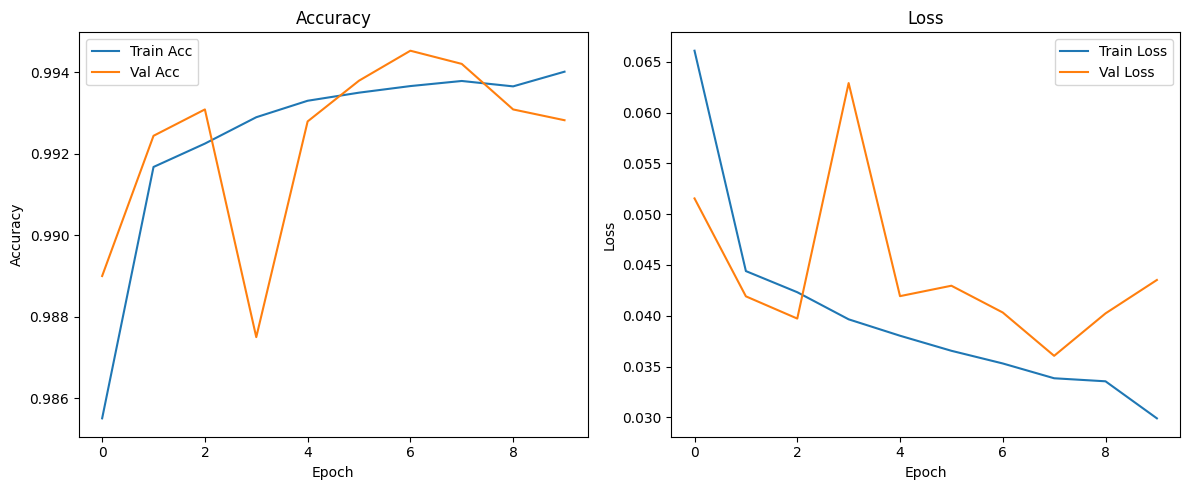

In [ ]:
import matplotlib.pyplot as plt

#Step 4: Train the Model

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Step 5: Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


# Step 6: Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy score
print("sklearn accuracy:", accuracy_score(y_test, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

1328/1328 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Confusion Matrix:
[[ 4362   269]
 [    0 37859]]

True Negatives (Benign correctly classified): 4362
False Positives (Benign misclassified as malware): 269
False Negatives (Malware missed): 0
True Positives (Malware correctly identified): 37859
sklearn accuracy: 0.993669098611438

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.94      0.97      4631
   Malicious       0.99      1.00      1.00     37859

    accuracy                           0.99     42490
   macro avg       1.00      0.97      0.98     42490
weighted avg       0.99      0.99      0.99     42490

